# arpav-ppcv-backend test notebook

This notebook has some interactive tests of time series data

We start off by doing some imports and initializing both the `settings` and a DB `session`, as these often come in handy

Then we proceed to get some sample data and ask for a the corresponding time series

In [1]:
%matplotlib widget

import logging

import httpx
import matplotlib.pyplot as plt
import pandas as pd
import shapely.io
import sqlmodel
from loess.loess_1d import loess_1d

from arpav_ppcv import (
    database as db,
    operations,
)
from arpav_ppcv.config import get_settings
from arpav_ppcv.schemas.base import (
    CoverageDataSmoothingStrategy,
    ObservationDataSmoothingStrategy,
    Season,
)

logging.basicConfig(level=logging.DEBUG)
logging.getLogger("httpx").setLevel(logging.WARNING)
logging.getLogger("httpcore").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

settings = get_settings()
session = sqlmodel.Session(db.get_engine(settings))
http_client = httpx.Client()

coverage_identifier = "tas_absolute-rcp26-DJF"
coverage_configuration = db.get_coverage_configuration_by_coverage_identifier(
    session, coverage_identifier)

POINT_GEOMS = {
    "near": shapely.io.from_wkt("POINT(11.5469 44.9524)"),
}

temporal_range = "../.."

In [7]:
time_series = operations.get_coverage_time_series(
    settings,
    session,
    http_client,
    coverage_configuration=coverage_configuration,
    coverage_identifier=coverage_identifier,
    point_geom=POINT_GEOMS["near"],
    temporal_range=temporal_range,
    include_coverage_data=True,
    include_observation_data=True,
    coverage_data_smoothing=[
        CoverageDataSmoothingStrategy.NO_SMOOTHING,
        CoverageDataSmoothingStrategy.LOESS_SMOOTHING,
        CoverageDataSmoothingStrategy.MOVING_AVERAGE_11_YEARS,
    ],
    observation_data_smoothing=[
        ObservationDataSmoothingStrategy.NO_SMOOTHING, 
        ObservationDataSmoothingStrategy.MOVING_AVERAGE_5_YEARS,
    ],
    include_coverage_uncertainty=False,
    include_coverage_related_data=False
)

/home/appuser/.cache/pypoetry/virtualenvs/arpav-ppcv-backend-f8CPI8sp-py3.10/lib/python3.10/site-packages/loess/loess_1d.py:81: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  a = x[:, None]**np.arange(degree + 1)
/home/appuser/.cache/pypoetry/virtualenvs/arpav-ppcv-backend-f8CPI8sp-py3.10/lib/python3.10/site-packages/loess/loess_1d.py:83: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.coeff = np.linalg.lstsq(a*sqw[:, None], y*sqw, rcond=None)[0]
/home/appuser/.cache/pypoetry/virtualenvs/arpav-ppcv-backend-f8CPI8sp-py3.10/lib/python3.10/site-packages/loess/loess_1d.py:81: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to 

In [8]:
station_series_name = [i for i in time_series.keys() if i.startswith("station")][0]

df1 = time_series[coverage_identifier]
df2 = time_series[station_series_name]

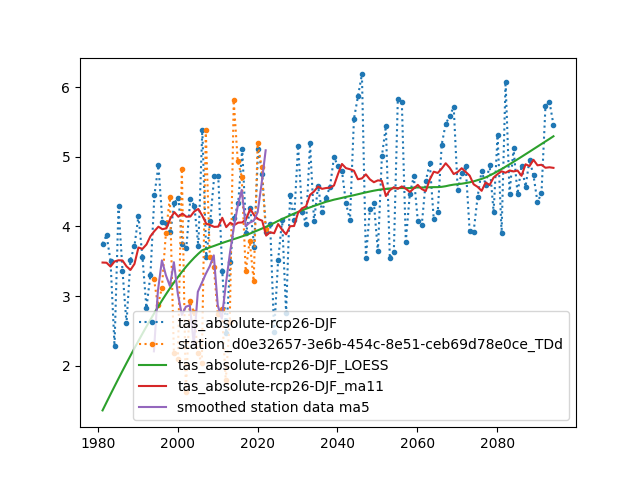

In [9]:
fig, ax = plt.subplots()

tas_line, = ax.plot(df1[f"{coverage_identifier}__NO_SMOOTHING"], label=coverage_identifier)
station_line, = ax.plot(df2[f"{coverage_configuration.related_observation_variable.name}__NO_SMOOTHING"], label=station_series_name)
tas_line.set_linestyle(":")
tas_line.set_marker(".")
station_line.set_linestyle(":")
station_line.set_marker(".")

loess_smoothed_tas_line, = ax.plot(df1[f"{coverage_identifier}__LOESS_SMOOTHING"], label=f"{coverage_identifier}_LOESS")
ma11_smoothed_tas_line, = ax.plot(df1[f"{coverage_identifier}__MOVING_AVERAGE_11_YEARS"], label=f"{coverage_identifier}_ma11")

mma5_smoothed_station_line = ax.plot(df2[f"{coverage_configuration.related_observation_variable.name}__MOVING_AVERAGE_5_YEARS"], label="smoothed station data ma5")

ax.legend()

In [6]:
ax.clear()